In [1]:
from stgraph_trainer.datasets import load_province_temporal_data
from stgraph_trainer.datasets import load_province_coordinates
from stgraph_trainer.datasets import preprocess_data_for_stgnn
from stgraph_trainer.utils import PairDataset
from stgraph_trainer.utils import compute_metrics
from stgraph_trainer.utils import matplotlib_plot_font
from stgraph_trainer.utils import save_figure_predict
from stgraph_trainer.datasets import Data2Graph
from torch.utils.data import DataLoader
from stgraph_trainer.models import TGCN, TGCNConv
from stgraph_trainer.trainers import TGCNTrainer
import torch
import numpy as np
import pandas as pd
import dgl
import scipy.sparse as sp

torch.manual_seed(42)
matplotlib_plot_font()

/opt/anaconda3/envs/venvGNN/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using TensorFlow backend.


In [3]:
MODEL_NAME = "TGCN"
TIME_STEPS = 5
BATCH_SIZE = 16
EPOCHS = 50
learning_rate = 1e-3
device = torch.device('cuda', 0) if torch.cuda.is_available() else torch.device('cpu')

region_type = 'state'
df = pd.read_csv(f'/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/KCDC_data/Processing_Results/smoothing_3_{region_type}_mean.csv', index_col=0, encoding='cp949')

df = df.iloc[100:700]


region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region 
    
# split_date = '2021-11-18'
split_date = '2021-06-25'
val_ratio = 0.2

In [4]:
df

,인천,서울,경기,전북,광주,전남,대구,경북,경남,충북,제주,부산,세종,강원,대전,울산,충남
신고일,,,,,,,,,,,,,,,,,
2020-04-30,0.333333,1.333333,2.000000,0.000000,0.000000,0.000000,0.666667,0.333333,0.333333,0.000000,0.000000,0.666667,0.000000,0.333333,0.000000,0.000000,0.000000
2020-05-01,0.666667,2.333333,2.666667,0.000000,0.000000,0.000000,1.000000,0.666667,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-02,1.000000,2.333333,2.666667,0.000000,0.000000,0.333333,1.000000,1.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000
2020-05-03,1.666667,2.000000,2.000000,0.000000,0.000000,0.333333,1.000000,0.666667,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.333333,0.000000
2020-05-04,1.333333,1.000000,1.333333,0.000000,0.000000,0.333333,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,0.000000,0.333333,0.000000,0.333333,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-16,553.666667,2904.333333,2306.333333,135.666667,48.333333,57.666667,167.000000,176.000000,197.000000,131.666667,32.333333,380.000000,27.000000,139.333333,153.333333,58.666667,196.333333
2021-12-17,547.666667,2723.666667,2165.333333,130.333333,47.333333,49.333333,176.333333,149.666667,209.666667,138.000000,30.333333,383.000000,35.000000,131.333333,142.666667,50.000000,208.666667
2021-12-18,498.666667,2411.333333,1937.666667,121.333333,42.666667,50.000000,157.000000,127.666667,207.000000,94.333333,27.000000,367.666667,34.333333,114.666667,141.666667,35.333333,205.666667


In [12]:
MODEL_NAME = "TGCN"
TIME_STEPS = 5
BATCH_SIZE = 16
EPOCHS = 50
learning_rate = 1e-3
device = torch.device('cuda', 0) if torch.cuda.is_available() else torch.device('cpu')

region_type = 'state'
df = pd.read_csv(f'/Users/jeonjunhwi/문서/Projects/Master_GNN/Data/KCDC_data/Processing_Results/smoothing_3_{region_type}_mean.csv', index_col=0, encoding='cp949')

# df = df.iloc[100:700]
df = df.iloc[100:554]

region_dict = {}
for i, region in enumerate(df.columns):
    region_dict[i] = region 
    
# split_date = '2021-11-18'
split_date = '2021-06-25'
val_ratio = 0.2

train, val, test, _, _, scaler = preprocess_data_for_stgnn(data = df,
                                                           val_ratio=val_ratio,
                                                           split_date=split_date,
                                                           time_steps=TIME_STEPS)
X_train, y_train = train[0], train[1]
X_val, y_val = val[0], val[1]
X_test, y_test = test[0], test[1]


X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(-1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)
n_test_samples = len(y_test)

train_dl = DataLoader(PairDataset(X_train, y_train),
                      batch_size=BATCH_SIZE,
                      shuffle=True)

val_dl = DataLoader(PairDataset(X_val, y_val),
                      batch_size=BATCH_SIZE,
                      shuffle=False)

test_dl = DataLoader(PairDataset(X_test, y_test),
                      batch_size=1,
                      shuffle=False)


dist_mx = pd.read_csv(f'data/distances_kr_{region_type}_adj_mx.csv', encoding='cp949', index_col=0)
norm = 0
data2network = Data2Graph(distance_matrix = dist_mx, temporal_data = df)
G, adj_mx, graph_type = data2network.make_network(network_type='complete',
                                                    region_type=region_type,
                                                    norm=norm,
                                                    int_adj=False) # 대체로 False가 더 좋았음.

# data2network.save_graph_html(enc=region_dict, title=region_type, save_name=f'{graph_type}_{norm}')

# Save Graph Diameter
import networkx as nx
G1 = G.to_networkx()
pd.DataFrame({'degree' : nx.degree_centrality(G1).values(),
              'eigenvector' : nx.eigenvector_centrality(nx.Graph(G1), max_iter=300).values(),
            #   'katz' : nx.katz_centrality(nx.Graph(G1), max_iter=3000).values(),
              'closeness' : nx.closeness_centrality(nx.Graph(G1)).values(),
              'betweness' : nx.betweenness_centrality(nx.Graph(G1)).values(),
              'clustering_coeff' : nx.clustering(nx.Graph(G1)).values()},
             index= dist_mx.index
             ).to_csv(f"Result/summary/{MODEL_NAME}_{graph_type}_{norm}_diameter.csv"
                 ,encoding='cp949')

In [19]:
date_split = f"{df.index[1]} ~ {df.index[len(train[0])]} ~ {df.index[len(train[0]) + len(val[0])+TIME_STEPS]} ~ {df.index[-1]}"
suptitle_ = f"{MODEL_NAME}_{graph_type}_{norm}_NAdam"
save_path = 'tgcnmodel.pt'

model = TGCNConv(adj_mx = adj_mx, hidden_dim=64, out_dim=16)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
trainer = TGCNTrainer(model = model,
                       train_loader = train_dl,
                       val_loader = val_dl,
                       test_loader = X_test.reshape(-1, len(df.columns),TIME_STEPS),
                       loss = loss_func,
                       optimizer = optimizer,
                       scaler = scaler,
                       device = device,
                       save_path = save_path,
                       length = len(df.columns),
                       TIME_STEPS = TIME_STEPS,
                       callbacks=None,
                       raw_test=df.iloc[-(n_test_samples + 1):].values)
                       

In [20]:
trainer.train(epochs=EPOCHS)

4.568126584276741
4.568126584276741 tgcnmodel.pt
Epoch: 1; Elapsed time: 0.4609100818634033; Train loss: 1.009552; Val MSE: 4.568127; Val loss RMSE: 2.137318
4.446137016202196
4.446137016202196 tgcnmodel.pt
Epoch: 2; Elapsed time: 0.4613349437713623; Train loss: 0.985989; Val MSE: 4.446137; Val loss RMSE: 2.108586
4.394487063090007
4.394487063090007 tgcnmodel.pt
Epoch: 3; Elapsed time: 0.6062140464782715; Train loss: 0.973466; Val MSE: 4.394487; Val loss RMSE: 2.096303
4.337337964846764
4.337337964846764 tgcnmodel.pt
Epoch: 4; Elapsed time: 0.47608399391174316; Train loss: 0.970977; Val MSE: 4.337338; Val loss RMSE: 2.082628
4.261313379546742
4.261313379546742 tgcnmodel.pt
Epoch: 5; Elapsed time: 0.5294778347015381; Train loss: 0.955085; Val MSE: 4.261313; Val loss RMSE: 2.064295
4.175818148954415
4.175818148954415 tgcnmodel.pt
Epoch: 6; Elapsed time: 0.5686371326446533; Train loss: 0.940240; Val MSE: 4.175818; Val loss RMSE: 2.043482
4.112789507265444
4.112789507265444 tgcnmodel.pt
Ep

{'epoch': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50],
 'train_loss': [1.0095523516337077,
  0.985989170273145,
  0.9734657078981399,
  0.9709771871566772,
  0.9550853163003922,
  0.9402398298184077,
  0.935213354229927,
  0.9265292455752691,
  0.9175496578216553,
  0.9230094254016876,
  0.9159913698832194,
  0.9164682398239772,
  0.9147820750872294,
  0.9066628098487854,
  0.9085470894972484,
  0.9051895598570506,
  0.904474143187205,
  0.911548822124799,
  0.9097669661045075,
  0.9018613944451014,
  0.9090310861666997,
  0.9026110420624415,
  0.905176908771197,
  0.9026843686898549,
  0.9017750973502795,
  0.901857300599416,
  0.9034530262152354,
  0.9038462122281392,
  0.9055771013100942,
  0.8980490297079087,
  0.9100615749756495,
  0.90131

In [13]:
# LOAD MODEL AND PREDICT DIFFERENT DURATION
model = TGCNConv(adj_mx = adj_mx, hidden_dim=100, out_dim=16)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)
date_split = f"{df.index[1]} ~ {df.index[len(train[0])]} ~ {df.index[len(train[0]) + len(val[0])+TIME_STEPS]} ~ {df.index[-1]}"        
save_path = "tgcnmodel.pt"
trainer = TGCNTrainer(model = model,
                       train_loader = train_dl,
                       val_loader = val_dl,
                       test_loader = X_test.reshape(-1, len(df.columns),TIME_STEPS),
                       loss = loss_func,
                       optimizer = optimizer,
                       scaler = scaler,
                       device = device,
                       save_path = save_path,
                       length = len(df.columns),
                       TIME_STEPS = TIME_STEPS,
                       callbacks=None,
                       raw_test=df.iloc[-(n_test_samples + 1):].values)

In [14]:
y_pred = trainer.predict()

torch.Size([28, 17, 1])


In [15]:
df2 = pd.DataFrame(y_pred,
             columns=df.columns,
             index=df.iloc[-n_test_samples:].index)
df2.to_csv(f'Result/pred/pred_TGCN_{graph_type}_{norm}.csv', encoding='cp949')

# Compute RMSE of test dataset
RMSE, RMSE_total = compute_metrics(df.iloc[-n_test_samples:], y_pred, metric='rmse')
MAE, MAE_total = compute_metrics(df.iloc[-n_test_samples:], y_pred, metric='mae')
MAPE, MAPE_total = compute_metrics(df.iloc[-n_test_samples:], y_pred, metric='mape')

df.iloc[-n_test_samples:].to_csv('Result/pred/ground_truth.csv', encoding='cp949')

In [16]:
MAE_total, MAPE_total, RMSE_total # 100 16

(5.788101363323854, 14.928533948847623, 11.24617211184408)

In [17]:
MAE_total, MAPE_total, RMSE_total # 64 16

(21.696356167366392, 10.104394089307833, 51.18312878792429)

In [10]:
MAE_total, MAPE_total, RMSE_total # 64 32

(21.441185714758824, 9.976240027297536, 50.603093748833665)

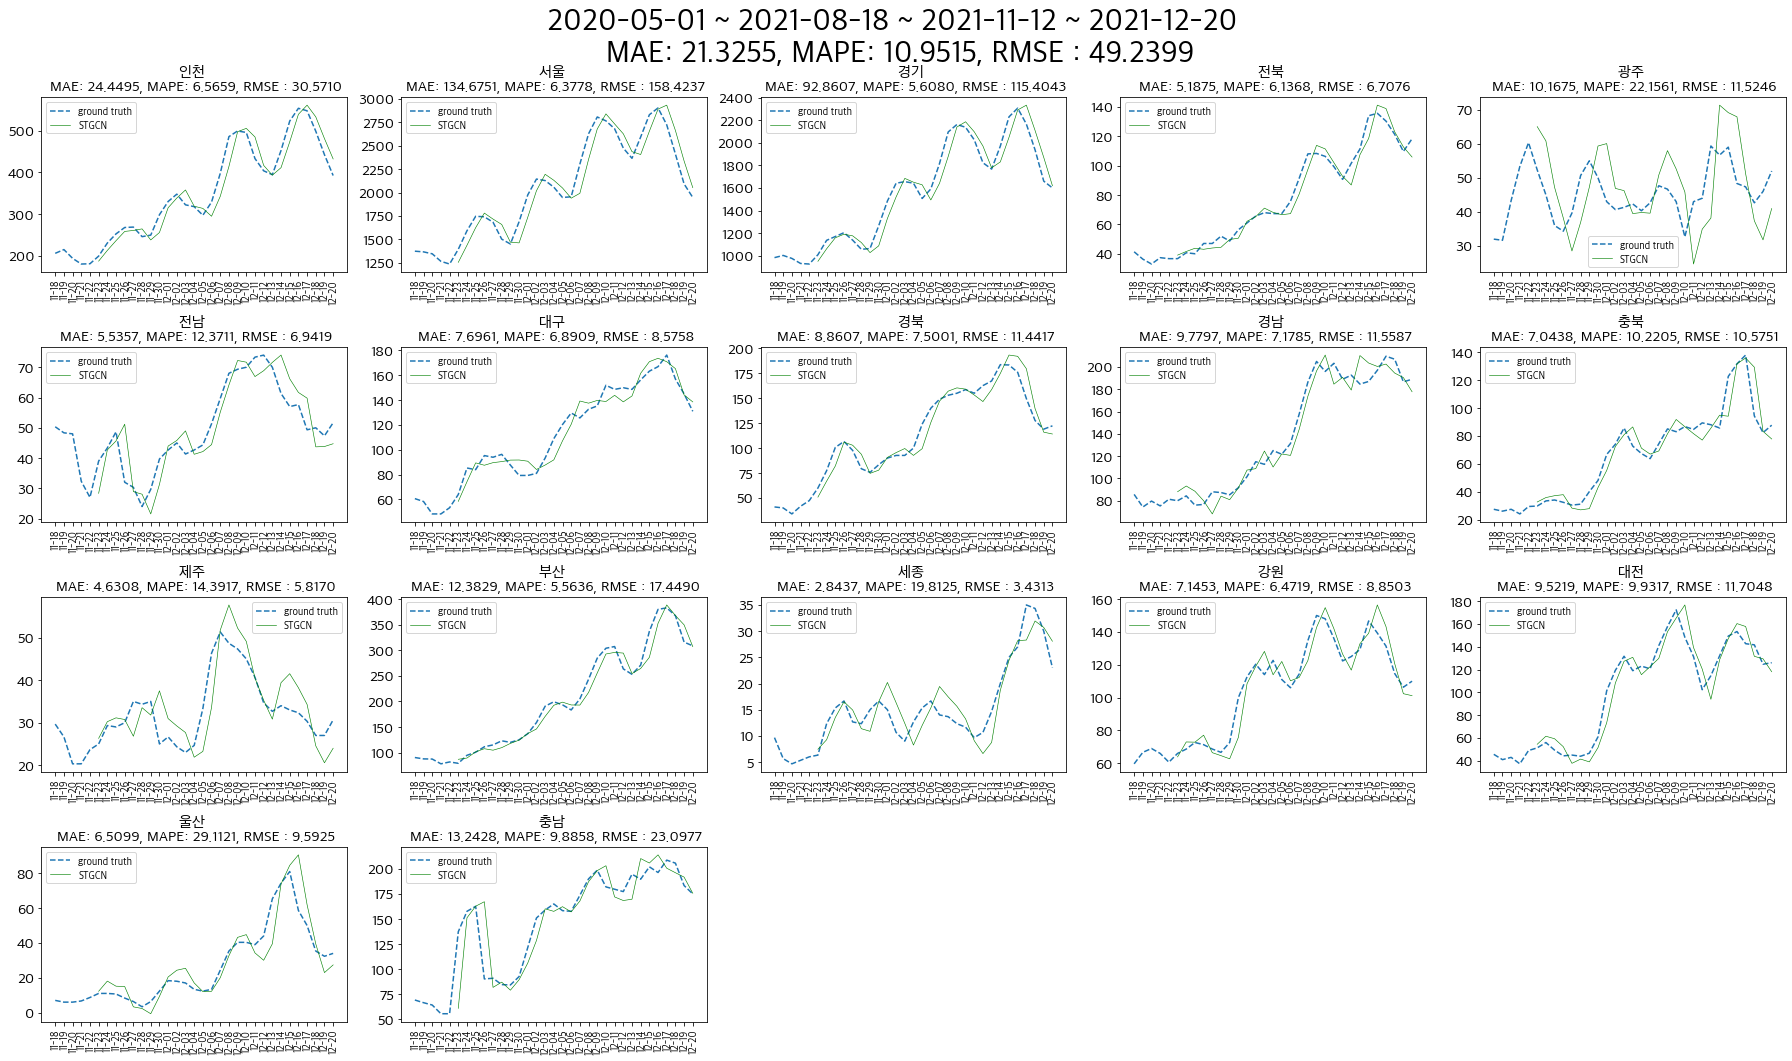

In [7]:
matplotlib_plot_font()
save_figure_predict(df, y_pred,
                    None, None, len(test[0]), TIME_STEPS,
                    region_dict, suptitle_,date_split,
                    MAE, MAPE, RMSE,
                    MAE_total, MAPE_total, RMSE_total, 
                    'Result/')
21.3255, 10.9515, 49.2399